1. Consider the boundary value problem:

$u'' = f, \quad u(0)=0, \quad u(1)=0$,

where

$f(x)=\begin{cases} 1 \quad 0.4\le x\le 0.6,\\
0 \quad \text{otherwise}.
\end{cases}$



*   Find the exact solution of this problem.
*   Solve the problem using finite difference method and check the accuracy of your solutions.

n = 200, h = 0.005
L2_h error = 0.0573451684974425
Max error = 0.09100000000000105


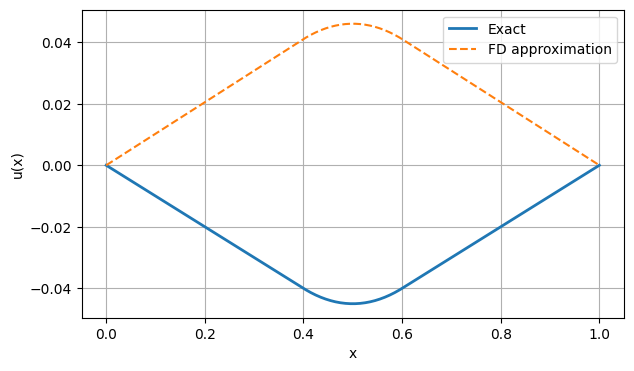

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the value and function
def u_exact(x):
    a, b, c, d, e = -0.1, -0.5, 0.08, 0.1, -0.1
    x = np.array(x)
    u = np.zeros_like(x)

    left = (x < 0.4)
    mid  = (x >= 0.4) & (x <= 0.6)
    right = (x > 0.6)

    u[left]  = a*x[left]
    u[mid]   = 0.5*x[mid]**2 + b*x[mid] + c
    u[right] = d*x[right] + e

    return u

def f(x):
    return np.where((x >= 0.4) & (x <= 0.6), 1.0, 0.0)

def thomas_solver(a, b, c, d):
    # a[i] * x[i-1] + b[i] * x[i] + c[i] * x[i+1] = d[i]
    n = len(b)
    cp = np.zeros(n)
    dp = np.zeros(n)

    cp[0] = c[0] / b[0]
    dp[0] = d[0] / b[0]

    for i in range(1, n):
        denom = b[i] - a[i] * cp[i-1]
        cp[i] = c[i] / denom if i < n - 1 else 0
        dp[i] = (d[i] - a[i] * dp[i-1]) / denom

    x = np.zeros(n)
    x[-1] = dp[-1]
    for i in reversed(range(n - 1)):
        x[i] = dp[i] - cp[i] * x[i + 1]

    return x


def solve_FD(n):
    h = 1.0 / n
    x = np.linspace(0, 1, n+1)

    # Construct tri-diagonal matrix
    a = -1/h**2 * np.ones(n-1)     # sub-diagonal
    b =  2/h**2 * np.ones(n-1)     # main diagonal
    c = -1/h**2 * np.ones(n-1)     # super-diagonal

    rhs = f(x[1:-1])               # interior points

    # Solve Au = f
    u_internal = thomas_solver(a, b, c, rhs)

    # Add boundary conditions
    u = np.zeros(n+1)
    u[1:n] = u_internal
    return x, u


if __name__ == "__main__":
    n = 200
    x, u_num = solve_FD(n)
    u_ex = u_exact(x)

    # Errors
    h = 1/n
    e = u_num - u_ex
    L2h = np.sqrt(h * np.sum(e[1:-1]**2))  # interior
    maxerr = np.max(np.abs(e))

    print(f"n = {n}, h = {h}")
    print(f"L2_h error = {L2h}")
    print(f"Max error = {maxerr}")

    # Plot
    plt.figure(figsize=(7,4))
    plt.plot(x, u_ex, label="Exact", linewidth=2)
    plt.plot(x, u_num, '--', label="FD approximation")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("u(x)")
    plt.grid(True)
    plt.show()


2. Consider the boundary value problem:

$u'' - 2u' + u = 1, \quad u(0)=0, \quad u'(1)=1.$



*   Show that the solution is unique by considering the homogeneous problem
*   Develop a 2nd-order finite difference method.
*   Solve the problem and check the accuracy of your solutions.





 n     h         L2_h          max_err
  20  5.00000e-02  8.06189e-02  1.83811e-01
  40  2.50000e-02  7.35737e-02  1.62902e-01
  80  1.25000e-02  6.96686e-02  1.52030e-01
 160  6.25000e-03  6.76146e-02  1.46483e-01
 320  3.12500e-03  6.65614e-02  1.43681e-01
Rate L2 between 20 and 40: 0.132
Rate L2 between 40 and 80: 0.079
Rate L2 between 80 and 160: 0.043
Rate L2 between 160 and 320: 0.023


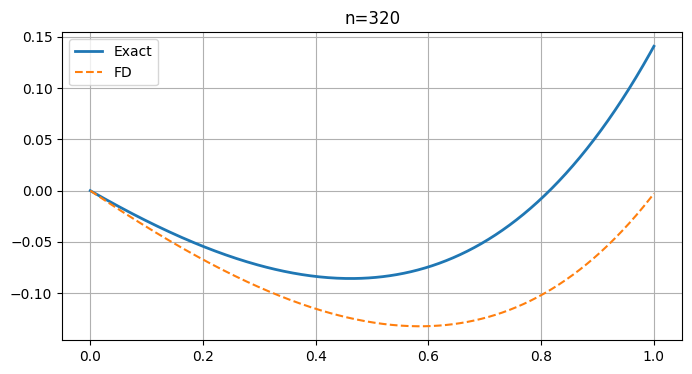

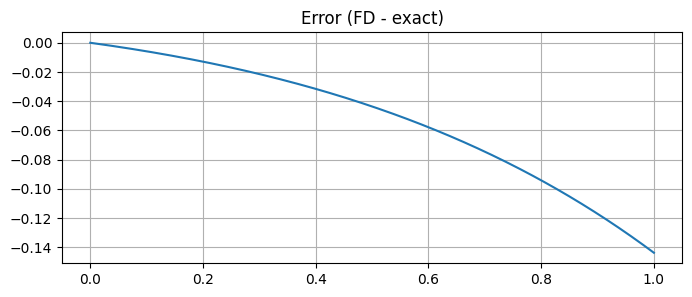

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set the value and function
def exact_u(x):
    # u(x) = (C1 + C2 x) e^x + 1, C1=-1, C2=(e^{-1}+1)/2
    C1 = -1.0
    C2 = (np.exp(-1.0) + 1.0)/2.0
    x = np.array(x)
    return (C1 + C2 * x) * np.exp(x) + 1.0

def assemble_system(n):
    # unknowns U = [u1,...,u_n]^T (length m = n)
    h = 1.0 / n
    m = n
    a = np.zeros(m-1)   # sub-diagonal (a[i] multiplies u_{i} for row i+1)
    b = np.zeros(m)     # main diagonal
    c = np.zeros(m-1)   # super-diagonal
    rhs = np.zeros(m)

    # interior equations (j=1..n-1 -> rows i=0..n-2)
    for i in range(0, m-1):
        a[i] = 1.0 + h      # coeff of u_{j-1}
        b[i] = -2.0 + h*h   # coeff of u_j
        c[i] = 1.0 - h      # coeff of u_{j+1}
        rhs[i] = h*h

    # last row: Neumann at x=1
    # coefficients for u_{n-2}, u_{n-1}, u_n are 1, -4, 3
    if m >= 3:
        a[m-2] = 1.0
    elif m == 2:
        a[0] = 1.0
    b[m-1] = -4.0
    rhs[m-1] = 2.0 * h

    return a, b, c, rhs, h


def thomas(a, b, c, d):
    # a: length m-1, b length m, c length m-1, d length m
    m = len(b)
    ac = a.copy()
    bc = b.copy()
    cc = c.copy()
    dc = d.copy().astype(float)
    # forward elimination
    for i in range(1, m):
        w = ac[i-1] / bc[i-1]
        bc[i] = bc[i] - w * cc[i-1]
        dc[i] = dc[i] - w * dc[i-1]
    # back substitution
    x = np.zeros(m)
    x[-1] = dc[-1] / bc[-1]
    for i in range(m-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x


def solve_fd(n):
    a,b,c,rhs,h = assemble_system(n)
    u_internal = thomas(a,b,c,rhs)   # solves for u1...u_n
    u = np.zeros(n+1)
    u[1:] = u_internal
    x = np.linspace(0,1,n+1)
    return x, u


if __name__ == "__main__":
    ns = [20,40,80,160,320]
    results = []
    for n in ns:
        x, u = solve_fd(n)
        ue = exact_u(x)
        h = 1.0/n
        err = u - ue
        L2h = np.sqrt(h * np.sum(err[1:-1]**2))   # interior L2_h
        maxerr = np.max(np.abs(err))
        results.append((n, h, L2h, maxerr))

    print(" n     h         L2_h          max_err")
    for n,h,L2h,maxerr in results:
        print(f"{n:4d}  {h:.5e}  {L2h:.5e}  {maxerr:.5e}")

    # compute rates between successive meshes
    for i in range(1,len(results)):
        n0,h0,e0,_ = results[i-1]
        n1,h1,e1,_ = results[i]
        rate = np.log(e0/e1)/np.log(h0/h1) if e1>0 else float('nan')
        print(f"Rate L2 between {n0} and {n1}: {rate:.3f}")

    # plot finest
    n = ns[-1]
    x,u = solve_fd(n)
    plt.figure(figsize=(8,4))
    plt.plot(x, exact_u(x), label='Exact', lw=2)
    plt.plot(x, u, '--', label='FD')
    plt.legend(); plt.title(f"n={n}"); plt.grid(True); plt.show()

    plt.figure(figsize=(8,3))
    plt.plot(x, u - exact_u(x))
    plt.title("Error (FD - exact)"); plt.grid(True); plt.show()


3. Consider the boundary value problem:

$u'' = \sin(2\pi x), \quad u'(0)=0, \quad u'(1)=0.$



*   Show that the consistency condition is satisfied so that the solution of the problem exists.
*   Develop a 2nd-order finite difference method.
*   Solve the problem and check the accuracy of your solutions.




   n        h          L2_h           max_err
  20   5.00000e-02   4.90764e-02   7.89219e-02
  40   2.50000e-02   4.75931e-02   7.94138e-02
  80   1.25000e-02   4.67876e-02   7.95366e-02
 160   6.25000e-03   4.63704e-02   7.95672e-02
 320   3.12500e-03   4.61583e-02   7.95749e-02

Convergence rates:
Rate between n=20 → n=40: 0.0443
Rate between n=40 → n=80: 0.0246
Rate between n=80 → n=160: 0.0129
Rate between n=160 → n=320: 0.0066


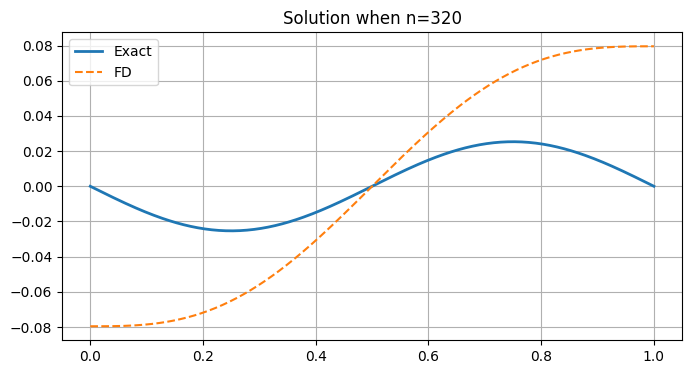

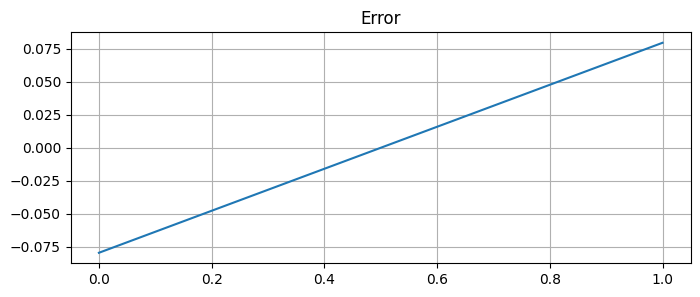

In [25]:
import numpy as np
import matplotlib.pyplot as plt


def exact_solution(x):
    # Solve u'' = sin(2 pi x)
    # u_p(x) = -sin(2 pi x)/(4 pi^2)
    u = -np.sin(2*np.pi*x)/(4*np.pi**2)

    # enforce mean zero
    mean_u = np.trapezoid(u, x)  # integral approx
    u = u - mean_u
    return u


def assemble_system(n):
    h = 1.0/n
    x = np.linspace(0,1,n+1)

    m = n+1   # number of nodes including endpoints

    # A u = f, but A is singular -> add mean(u)=0 as last eq
    # So number of unknowns = m, number of equations = m
    A = np.zeros((m,m))
    b = np.zeros(m)

    # interior nodes j=1..n-1
    for j in range(1, n):
        A[j, j-1] = 1.0/h**2
        A[j, j]   = -2.0/h**2
        A[j, j+1] = 1.0/h**2
        b[j] = np.sin(2*np.pi*x[j])

    # Neumann at x=0: u'(0)=0 => u_1 - u_(-1)=0 => u_(-1)=u_1
    # Discrete equation (ghost eliminated):
    # (2u_1 - 2u_0)/h^2 = f(0)=0
    A[0, 0] = -2.0/h**2
    A[0, 1] =  2.0/h**2
    b[0] = 0

    # Neumann at x=1: u'(1)=0 => u_{n+1}=u_{n-1}
    # (2u_{n-1} - 2u_n)/h^2 = f(1)=0
    A[n, n]   = -2.0/h**2
    A[n, n-1] =  2.0/h**2
    b[n] = 0

    # Add mean(u)=0 constraint (replace last equation)
    A[n,:] = 1.0        # sum_j u_j = 0
    b[n] = 0.0

    return A, b, x


def solve_fd(n):
    A, b, x = assemble_system(n)
    u = np.linalg.solve(A, b)
    ue = exact_solution(x)

    err = u - ue
    h = 1.0/n
    L2h = np.sqrt(h * np.sum(err**2))
    maxerr = np.max(np.abs(err))

    return x, u, ue, L2h, maxerr


if __name__ == "__main__":
    ns = [20, 40, 80, 160, 320]
    print("   n        h          L2_h           max_err")
    results = []

    for n in ns:
        x, u, ue, L2h, maxerr = solve_fd(n)
        h = 1.0/n
        results.append((n,h,L2h,maxerr))
        print(f"{n:4d}   {h:8.5e}   {L2h:10.5e}   {maxerr:10.5e}")

    # compute convergence rates
    print("\nConvergence rates:")
    for k in range(1,len(results)):
        n0,h0,e0,_ = results[k-1]
        n1,h1,e1,_ = results[k]
        rate = np.log(e0/e1)/np.log(h0/h1)
        print(f"Rate between n={n0} → n={n1}: {rate:.4f}")

    # plot solution for the finest grid
    n = ns[-1]
    x,u,ue,_,_ = solve_fd(n)

    plt.figure(figsize=(8,4))
    plt.plot(x, ue, label="Exact", lw=2)
    plt.plot(x, u, '--', label="FD")
    plt.legend()
    plt.grid(True)
    plt.title(f"Solution when n={n}")
    plt.show()

    plt.figure(figsize=(8,3))
    plt.plot(x, u-ue)
    plt.title("Error")
    plt.grid(True)
    plt.show()


4. Consider the boundary value problem:

$u'' = e^{\sin(x)}, \quad u'(0)=0, \quad u'(1)=\alpha.$



*   Determine $\alpha$ such that the problem has at least one solution.
*   Solve the problem by finding one of its solution.




alpha ≈ 1.631869608471
Check: constructed u'(1) ≈ 1.631869613697

FD comparison:
 n=  50, h=2.00000e-02, L2_h=2.682e-03, maxerr=2.724e-03
 n= 100, h=1.00000e-02, L2_h=1.348e-03, maxerr=1.358e-03
 n= 200, h=5.00000e-03, L2_h=6.757e-04, maxerr=6.783e-04
 n= 400, h=2.50000e-03, L2_h=3.383e-04, maxerr=3.389e-04


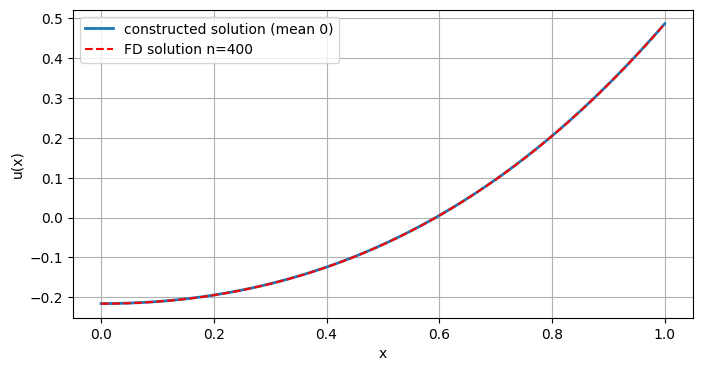

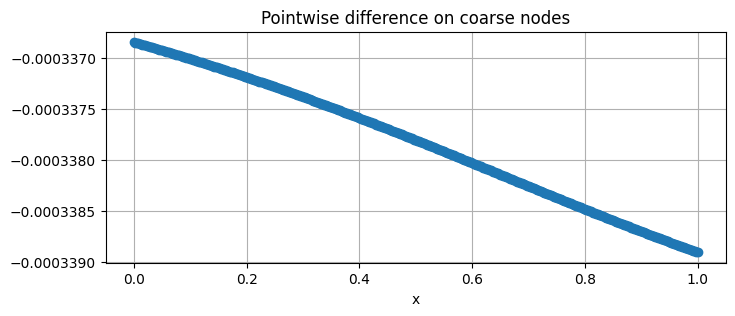

In [27]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.exp(np.sin(x))

def compute_alpha(N=20001):
    x = np.linspace(0, 1, N)
    fx = f(x)
    alpha = np.trapezoid(fx, x)
    return alpha

def construct_solution(x):
    # x: array of nodes from 0..1
    h = x[1] - x[0]
    fx = f(x)
    # u'(x) = ∫_0^x f(t) dt, use cumulative trapezoid
    uprime = np.zeros_like(x)
    # cumulative trap: uprime[k] = integral from x0..xk
    uprime[1:] = np.cumsum(0.5*(fx[:-1] + fx[1:]) * h)
    # u(x) = ∫_0^x uprime(s) ds + C ; choose C so mean(u)=0 for uniqueness
    u = np.zeros_like(x)
    u[1:] = np.cumsum(0.5*(uprime[:-1] + uprime[1:]) * h)
    # shift to mean zero (optional, makes comparison with FD with mean constraint direct)
    mean_u = np.trapezoid(u, x)
    u_shift = u - mean_u
    return uprime, u_shift

def assemble_neumann_fd(n):
    # nodes 0..n, h = 1/n
    h = 1.0 / n
    x = np.linspace(0, 1, n+1)
    m = n+1
    A = np.zeros((m, m))
    b = np.zeros(m)
    # interior nodes j=1..n-1
    for j in range(1, n):
        A[j, j-1] = 1.0 / h**2
        A[j, j]   = -2.0 / h**2
        A[j, j+1] = 1.0 / h**2
        b[j] = f(x[j])
    # left Neumann (ghost elimination): (2 u1 - 2 u0)/h^2 = f(0)
    A[0,0] = -2.0 / h**2
    A[0,1] =  2.0 / h**2
    b[0] = f(0.0)
    # right Neumann: (2 u_{n-1} - 2 u_n)/h^2 = f(1)
    A[n,n]   = -2.0 / h**2
    A[n,n-1] =  2.0 / h**2
    b[n] = f(1.0)
    # replace last equation by mean(u)=0 to fix additive constant
    A[-1,:] = 1.0
    b[-1] = 0.0
    return A, b, x, h


if __name__ == "__main__":
    alpha = compute_alpha(N=20001)
    print(f"alpha ≈ {alpha:.12f}")

    Nfine = 2001
    x_fine = np.linspace(0, 1, Nfine)
    uprime_fine, u_construct = construct_solution(x_fine)
    print(f"Check: constructed u'(1) ≈ {uprime_fine[-1]:.12f}")

    print("\nFD comparison:")
    for n in [50, 100, 200, 400]:
        A, b, x, h = assemble_neumann_fd(n)
        u_fd = np.linalg.solve(A, b)              # solves for u on nodes
        # construct analytical solution on the same coarse nodes
        uprime_c, u_c = construct_solution(x)
        # u_c already shifted to mean zero, FD uses mean constraint too -> compare directly
        err = u_fd - u_c
        L2h = np.sqrt(h * np.sum(err**2))
        maxerr = np.max(np.abs(err))
        print(f" n={n:4d}, h={h:.5e}, L2_h={L2h:.3e}, maxerr={maxerr:.3e}")

    nplot = 400
    A, b, x_coarse, h = assemble_neumann_fd(nplot)
    u_fd = np.linalg.solve(A, b)
    uprime_c, u_c = construct_solution(x_coarse)

    plt.figure(figsize=(8,4))
    plt.plot(x_fine, u_construct, label="constructed solution (mean 0)", lw=2)
    plt.plot(x_coarse, u_fd, 'r--', label=f"FD solution n={nplot}")
    plt.xlabel('x'); plt.ylabel('u(x)')
    plt.legend(); plt.grid(True);
    plt.show()

    plt.figure(figsize=(8,3))
    plt.plot(x_coarse, u_fd - u_c, marker='o')
    plt.title('Pointwise difference on coarse nodes')
    plt.xlabel('x'); plt.grid(True)
    plt.show()

5. Consider the linear boundary value problem:

$\epsilon u'' + (1+\epsilon) u' + u = 0, \quad u(0)=0, \quad u(1)=1.$

Solve the problem and check the accuracy of your solutions. Choose
$\epsilon=0.01$


=== Scheme: central ===
n=  50, h=2.000e-02, L2_h=5.441e-02, max_err=3.815e-01
n= 100, h=1.000e-02, L2_h=1.249e-02, max_err=9.693e-02
n= 200, h=5.000e-03, L2_h=2.977e-03, max_err=2.207e-02
n= 400, h=2.500e-03, L2_h=7.329e-04, max_err=5.402e-03
n= 800, h=1.250e-03, L2_h=1.825e-04, max_err=1.343e-03

Empirical L2 rates:
50->100: rate ≈ 2.123
100->200: rate ≈ 2.069
200->400: rate ≈ 2.022
400->800: rate ≈ 2.006

=== Scheme: upwind ===
n=  50, h=2.000e-02, L2_h=1.924e+00, max_err=2.854e+00
n= 100, h=1.000e-02, L2_h=1.083e-01, max_err=1.014e+00
n= 200, h=5.000e-03, L2_h=4.064e-02, max_err=3.222e-01
n= 400, h=2.500e-03, L2_h=1.835e-02, max_err=1.405e-01
n= 800, h=1.250e-03, L2_h=8.789e-03, max_err=6.622e-02

Empirical L2 rates:
50->100: rate ≈ 4.151
100->200: rate ≈ 1.414
200->400: rate ≈ 1.147
400->800: rate ≈ 1.062


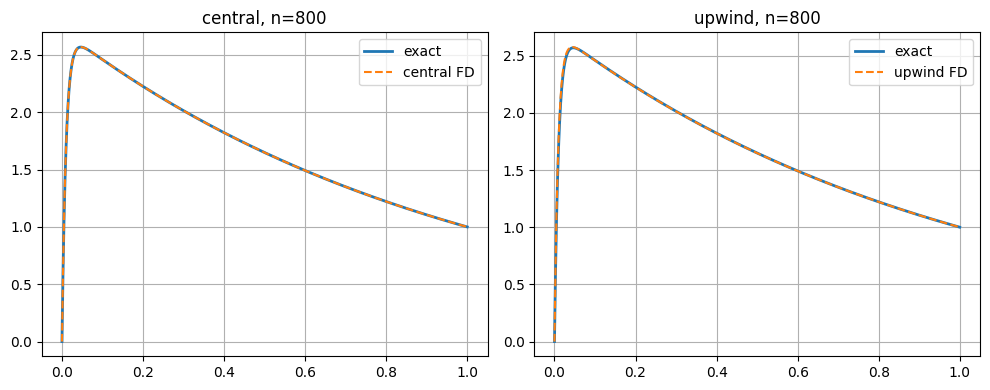

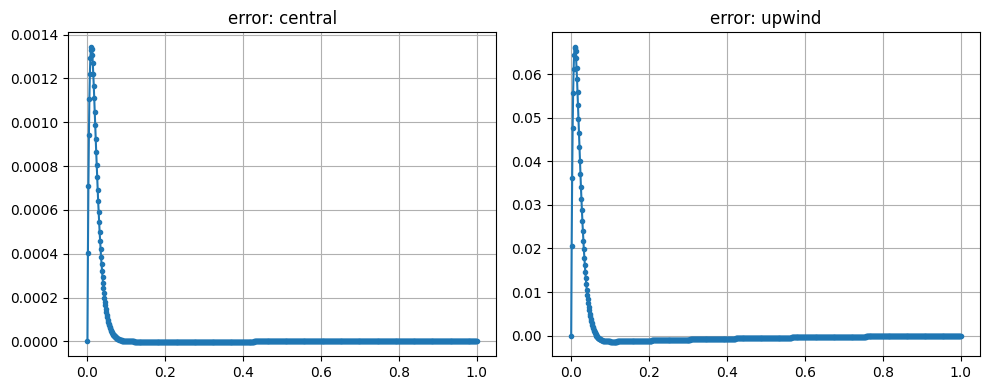


Characteristic roots r1, r2: -100.0 -1.0
Exact u(0), u(1): [-0.  1.]


In [29]:
import numpy as np
import matplotlib.pyplot as plt


eps = 0.01
schemes = ["central", "upwind"]   # will run both
ns = [50, 100, 200, 400, 800]     # grid sizes to test

# Solve eps r^2 + (1+eps) r + 1 = 0
# u(x) = C1 e^{r1 x} + C2 e^{r2 x}, apply u(0)=0, u(1)=1
# => C2 = -C1, C1 (e^{r1} - e^{r2}) = 1 => explicit formula
coef = [eps, (1.0 + eps), 1.0]
r = np.roots(coef)   # roots r[0], r[1]
r1, r2 = r[0], r[1]

def u_exact(x):
    # handle case r1 ~= r2 (double root) numerically unlikely here
    num = np.exp(r1 * x) - np.exp(r2 * x)
    den = np.exp(r1) - np.exp(r2)
    return num / den

# a: sub-diagonal (len m-1), b: main (len m), c: super (len m-1)
def thomas(a, b, c, d):
    m = len(b)
    ac = a.copy().astype(float)
    bc = b.copy().astype(float)
    cc = c.copy().astype(float)
    dc = d.copy().astype(float)
    # forward elimination
    for i in range(1, m):
        w = ac[i-1] / bc[i-1]
        bc[i] = bc[i] - w * cc[i-1]
        dc[i] = dc[i] - w * dc[i-1]
    # back substitution
    x = np.zeros(m, dtype=float)
    x[-1] = dc[-1] / bc[-1]
    for i in range(m-2, -1, -1):
        x[i] = (dc[i] - cc[i] * x[i+1]) / bc[i]
    return x


def build_system(n, scheme="central"):
    h = 1.0 / n
    m = n - 1               # number of unknowns (u1..u_{n-1})
    a = np.zeros(m-1)       # sub
    b = np.zeros(m)         # main
    c = np.zeros(m-1)       # super
    rhs = np.zeros(m)
    if scheme == "central":
        coef_a = eps/h**2 - (1.0 + eps)/(2.0*h)
        coef_b = -2.0*eps/h**2 + 1.0
        coef_c = eps/h**2 + (1.0 + eps)/(2.0*h)
        # fill
        if m >= 2:
            a[:] = coef_a
            c[:] = coef_c
        b[:] = coef_b
        # RHS initially zero, but adjust last equation for u_n = 1
        # For j = n-1 (index m-1), term c * u_n moves to RHS: rhs = -c * u_n
        if m >= 1:
            rhs[-1] = -coef_c * 1.0
    elif scheme == "upwind":
        # backward upwind for positive advection (1+eps > 0)
        coef_a = eps/h**2 - (1.0 + eps)/h
        coef_b = -2.0*eps/h**2 + (1.0 + eps)/h + 1.0
        coef_c = eps/h**2
        if m >= 2:
            a[:] = coef_a
            c[:] = coef_c
        b[:] = coef_b
        if m >= 1:
            rhs[-1] = -coef_c * 1.0
    else:
        raise ValueError("Unknown scheme")
    return a, b, c, rhs

def run_experiment(scheme):
    print(f"\n=== Scheme: {scheme} ===")
    results = []
    sols = {}
    for n in ns:
        a, b, c, rhs = build_system(n, scheme=scheme)
        # Solve tridiagonal for u1..u_{n-1}
        if len(b) == 0:
            # trivial small n edge
            u_internal = np.array([])
        else:
            u_internal = thomas(a, b, c, rhs)
        # full solution including boundaries
        u = np.zeros(n+1)
        u[1:-1] = u_internal
        u[-1] = 1.0
        x = np.linspace(0,1,n+1)
        ue = u_exact(x)
        err = u - ue
        h = 1.0 / n
        L2h = np.sqrt(h * np.sum(err**2))
        maxerr = np.max(np.abs(err))
        results.append((n, h, L2h, maxerr))
        sols[n] = (x, u, ue, err)
        print(f"n={n:4d}, h={h:.3e}, L2_h={L2h:.3e}, max_err={maxerr:.3e}")
    # compute empirical rates for L2h
    print("\nEmpirical L2 rates:")
    for i in range(1, len(results)):
        n0, h0, e0, _ = results[i-1]
        n1, h1, e1, _ = results[i]
        rate = np.log(e0/e1) / np.log(h0/h1) if e1>0 else np.nan
        print(f"{n0}->{n1}: rate ≈ {rate:.3f}")
    return sols


sols_central = run_experiment("central")
sols_upwind  = run_experiment("upwind")

nplot = ns[-1]
x_c, u_c, ue_c, err_c = sols_central[nplot]
x_u, u_u, ue_u, err_u = sols_upwind[nplot]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_c, ue_c, label="exact", lw=2)
plt.plot(x_c, u_c, '--', label="central FD")
plt.title(f"central, n={nplot}")
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x_u, ue_u, label="exact", lw=2)
plt.plot(x_u, u_u, '--', label="upwind FD")
plt.title(f"upwind, n={nplot}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(x_c, err_c, '-o', markersize=3)
plt.title("error: central")
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(x_u, err_u, '-o', markersize=3)
plt.title("error: upwind")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nCharacteristic roots r1, r2:", r1, r2)
xchk = np.array([0.0, 1.0])
print("Exact u(0), u(1):", u_exact(xchk))
